In [6]:
#Start by importing the required libraries.

import numpy as np
import matplotlib.pyplot as plt
import math

Define a whole bunch of nifty functions!

If you made it this far, I recommend that you play around with:

- generateEHP(), which performs a single simulation of EHP generation and termination
- mcSimulation(), which iterates generateEHP() multiple times to yield data about cell performance

Make sure to change the argument "vis" from 0 to 1 to see the visuals!

In [7]:
#Elementary functions

def mobileCarriers(m,n,c):
    """
    Description: 
    - Generates a randomized assortment of mobile charge carriers (hole and electrons) throughout semiconductor lattice.
    Inputs: 
    - m is the row count (or depth of lattice)
    - n is column count (or width of lattice)
    - c is the bulk doping density in ppt. Number of electrons = 0.001 * c * m * n 
    Outputs: List containing starting position and elementary charge of all charge carriers. 
    """
    uniquePositions = False
    while uniquePositions == False:

        def rd2Dpos(m,n):
            return (np.random.randint(1,m-1),np.random.randint(1,n-1))

        # Starting location of EHP-generated hole
        h0 = (rd2Dpos(m,n),1)

        # Starting location of EHP-generated electron. Must be adjacent to hole.
        e0 = h0
        while e0[0] == h0[0]:
            e0 = ((h0[0][0] + np.random.choice([-1,0,1]), h0[0][1] + np.random.choice([-1,0,1])),-1)
        
        # Set up array to contain all charge carriers
        carriers = [[h0]]
        carriers.append([e0])

        # Starting location of free electrons from bulk doping.
        n_e = 0.001 * c * m * n #Number of electrons
        for _ in range(int(n_e)):
            carriers.append([((rd2Dpos(m,n)),-1)])

        #Final check. If any carriers occupy the same location, re-roll the starting positions.
        for i in range(len(carriers)):
            for j in range(len(carriers)):
                if carriers[i][0] == carriers[j][0] and i != j:
                    uniquePositions = False
                else:
                    uniquePositions = True

    return carriers

def transportLayer(n,tlQ,d):
    """ 
    Description:
    Approximates the interdigitated back contact layer as a series of potent point charges.
    
    Inputs: 
    - n is the total width of the m x n system. 
    - q is the electrical charge of the transport layer. 
    - d is the degree of interdigitation along the width of the system. 
    -- Example: 1 = A single p-n junction. 2 = 2 p-types and 2 n-type regions.
    
    Output: 
    Provides a list of positions and electrical charges simulating the n-type and p-type 
    transport layers for charge carrier collection
    """
    #Start by sectioning out the back contact layer into n-type and p-type regions.
    regions = np.array_split(range(n), d*2)

    #Every even index is a n-type and every odd index is an p-type.
    transportLayer = []
    for i in range(len(regions)):
        if (i%2) == 0: # Check for even index.
            for j in range(len(regions[i])):
                transportLayer.append(((0,regions[i][j]),tlQ)) # N-type doping results in positive charge when depleted.
        else: #If not even, then odd index.
            for j in range(len(regions[i])):
                transportLayer.append(((0,regions[i][j]),-tlQ)) # P-type doping results in negative change when depleted.

    return transportLayer

def pointCharges(mC, tL):
    """
    Description:
    Concatenate list of all point charges from transport layer and mobile carriers

    Inputs:
    - mC = Mobile carrier array
    - tL = Transport layer array
    """
    pointCharges = []
    for i in range(len(mC)):
        pointCharges.append(mC[i][-1]) #Take only the last updated position of each mobile carrier
    pointCharges = pointCharges + tL

    return pointCharges

def energyField(mC_i, pQ, m, n, T, k_th=1, k_e=1):
    """
    Inputs:
    - mC_i = mobile carrier index
    - pQ = point charge array (includes position and electric charge)
    - m = rows
    - n = columns
    - T = temperature
    - k_th = relative coefficient for kinetic energy
    - k_e = relative coefficient for eletrostatic potential energy

    Output: 
    Probability field for charge carrier movement direction based on energetic driving forces.
    [Up, Down, Left, Right]
    """

    #Kinetic energy in all directions due to thermal excitation
    kinE = k_th*T

    #Potential energy from Coulombic interactions across all charged species
    potE_up = 0
    potE_down = 0
    potE_left = 0
    potE_right = 0

    for i in range(len(pQ)):
        if i != mC_i: #No need to measure self-interaction
            
            r = math.dist(pQ[mC_i][0],pQ[i][0]) #Distance between point charges
            if r == 0:
                continue

            v = pQ[mC_i][0][0] - pQ[i][0][0]    #Vertical difference (row-wise)
            h = pQ[mC_i][0][1] - pQ[i][0][1]    #Horizontal difference (column-wise)
            q1 = pQ[mC_i][1]                    #Electric charge of mobile carrier
            q2 = pQ[i][1]                       #Electric charge of interacting body

            #Magnitude of electrostatic interaction
            potE = k_e * q1 * q2 / r      
            
            #Vertical component of electrostatic interaction
            potE_v = potE * v/r 
            potE_up   += potE_v/2
            potE_down -= potE_v/2

            #Horizontal component of electrostatic interaction
            potE_h = potE * h/r
            potE_left  -= potE_h/2
            potE_right += potE_h/2 

    #Probabilty field mediated by energetic driving force. If the probability is negative, round up to zero.
    def minLimit(x,min):
        if x < min:
            return min
        else:
            return x
    up    = minLimit(kinE + potE_up,0)
    down  = minLimit(kinE + potE_down,0)
    left  = minLimit(kinE + potE_left,0)
    right = minLimit(kinE + potE_right,0)
    
    # Infinite potential energy gap preventing migration outside the boundaries of the system
    if pQ[mC_i][0][0] == 0:
        down = 0
    elif pQ[mC_i][0][0] == m-1:
        up = 0
    if pQ[mC_i][0][1] == 0:
        left = 0
    elif pQ[mC_i][0][1] == n-1:
        right = 0

    events = [up, down, left, right]

    return events

def lightAbsorption(x,a=0.1,i_0=0.1):
    abs = i_0 * (1 - np.exp(-a*x))/a
    return abs

#Monte Carlo simulations

def generateEHP(m,n,c,tlQ,d,T,vis=0):
    """
    Description:
    Performs a single random walk simulation for mobile charge carriers.

    Inputs:
    - m = bulk lattice depth (or rows)
    - n = bulk lattice width (or columns)
    - c = bulk doping concentration (N_electrons = m * n * c / 1000)
    - T = temperature (absolute)
    - tlQ = transport layer charge
    - d = degree of interdigitation
    
    Outputs:
    - total current
    - efficiency
    - diffusion lengths
    """

    mC = mobileCarriers(m,n,c)
    tL = transportLayer(n,tlQ,d)

    recombination = 0
    collection = 0
    breakflag = 0
    steps = 0

    # Store the paths of all mobile carriers
    paths = [[] for _ in range(len(mC))]

    #While loop allowing for succesive steps until recombination or collection event
    while breakflag == 0:

        pQ = pointCharges(mC,tL)

        #For loop stepping through each mobile carrier, updating position, and checking for overlap
        for i in range(len(mC)): 

            # Random movement
            eF = energyField(i,pQ,m,n,T)
            cE = np.cumsum(eF)              #Generate an array of cumulative sum of eF array elements, the "cumulative Energy"
            u = np.random.uniform(0,cE[-1]) #"u" is a random value selected linearly between 0 and the sum of the energies.
            event = np.searchsorted(cE,u)

            last_row = mC[i][-1][0][0]
            last_col = mC[i][-1][0][1]
            charge   = mC[i][-1][1]

            if event == 0: #Up
                next_row = last_row + 1
                next_col = last_col
            elif event == 1: #Down
                next_row = last_row - 1
                next_col = last_col
            elif event == 2: #Left
                next_row = last_row
                next_col = last_col - 1 
            elif event == 3: #Right
                next_row = last_row
                next_col = last_col + 1

            #Add to the path record
            mC[i].append(((next_row, next_col), charge))
            paths[i].append((next_row, next_col))

            #Check for overlap between charge carriers
            #Evaluate for hole (i=0)
            if i == 0:
                #Evaluate over mobile carriers
                for j in range(len(mC)):
                    if j != 0 and mC[i][-1][0] == mC[j][-1][0]:
                        recombination = 1
                        breakflag = 1
                        break
                #Evaluate over transport layer
                for j in range(len(tL)):
                    if mC[i][-1][0] == tL[j][0]:
                        if tL[j][1] > 0: #n-type
                            recombination = 1
                            breakflag = 1
                            break
                        elif tL[j][1] < 0: #p-type
                            collection = 1
                            breakflag = 1
                            break
            if breakflag == 1:
                break

            #Evaluate for electrons (i>0) overlapping with hole
            if i>0 and mC[i][-1][0] == mC[0][-1][0]:
                recombination = 1
                breakflag = 1
                break
        steps += 1

    if vis == 1:
        # Plot the paths of all mobile carriers
        for i, path in enumerate(paths):
            if i == 0:
                color = 'red'  # Hole
            else:
                color = 'blue'  # Electrons
            x_coords = [pos[1] for pos in path]
            y_coords = [pos[0] for pos in path]
            plt.plot(x_coords, y_coords, color=color)

        # Plot the final position of each charge carrier as a solid marker
        for i, path in enumerate(paths):
            if i == 0:
                color = 'red'  # Hole
            else:
                color = 'blue'  # Electrons
            final_pos = path[-1]
            plt.plot(final_pos[1], final_pos[0], marker='o', markersize=8, color=color)

        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.title('Mobile Carrier Paths')
        plt.grid(True)
        plt.figure(figsize=(5,1))
        plt.show()

    return steps, recombination, collection

def mcSimulation(iter,m,n,c,T,tlQ,d,vis=0):

    """
    Description:
    - Kinetic Monte Carlo iterative simulation of mobile charge carrier movement.

    Inputs:
    - iter = number of iterations
    - m = bulk lattice depth (or rows)
    - n = bulk lattice width (or columns)
    - c = bulk doping concentration (N_electrons = m * n * c / 1000)
    - T = temperature (absolute)
    - tlQ = transport layer charge
    - d = degree of interdigitation

    Outputs:
    - total current
    - efficiency
    - diffusion lengths
    """

    ct_recombination = 0
    ct_collection    = 0
    diffLens = []

    for i in range(iter):
        dL, recombination, collection = generateEHP(m,n,c,tlQ,d,T)
        if recombination == 1:
            ct_recombination += 1
        elif collection == 1:
            ct_collection += 1
            diffLens.append(dL)

    #The conversion rate is a count of how many holes were collected per EHP generation event
    convEff = ct_collection/iter

    #The median diffusion length provides a measure for how long it takes for the hole to reach the transport layer.
    diffLen_med = np.median(diffLens)
    diffLen_avg = np.average(diffLens)

    #Current density  
    abs = lightAbsorption(m)
    currentDensity = convEff * abs * c
    
    if vis == 1:
        plt.figure(figsize=(5,2))
        plt.hist(diffLens, bins=15, edgecolor='black')
        plt.xlabel('Diffusion Length')
        plt.ylabel('Frequency')
        plt.title('Distribution of Diffusion Lengths')
        plt.show()

        print("The total current is " + str(currentDensity))
        print("The conversion efficiency is " + str(convEff))
        print("The median diffusion length is "+ str(diffLen_med))
        print("The average diffusion length is " + str(diffLen_avg))

    return currentDensity, convEff, diffLen_med, diffLen_avg, diffLens

In [8]:
#Sample inputs, for your convenience

iter = 10     #Number of simulations
m = 15          #Bulk lattice depth
n = 100         #Bulk lattice width
c = 5           #Doping concentration
T = 1           #Temperature
tlQ = 2         #Transport layer charge
d = 4           #Degree of interdigitation

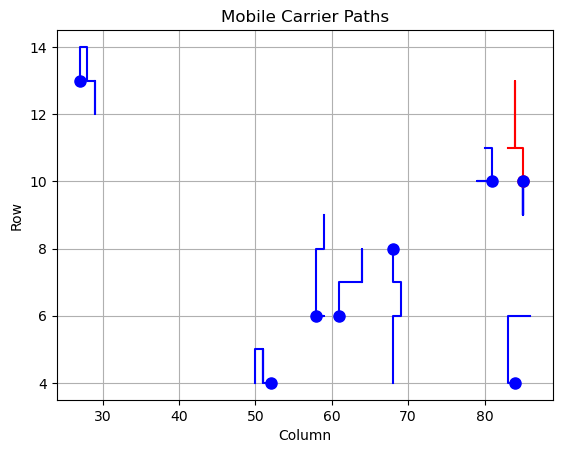

<Figure size 500x100 with 0 Axes>

(8, 1, 0)

In [9]:
#Sometimes a graph doesn't appear. That is due to immediate recombination on the first step.
generateEHP(m,n,c,tlQ,d,T,vis=1)

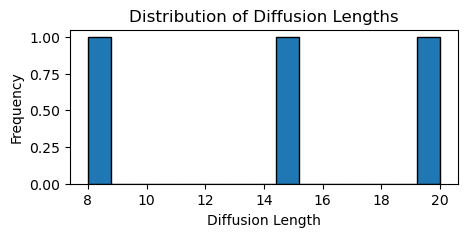

The total current is 1.1653047597773551
The conversion efficiency is 0.3
The median diffusion length is 15.0
The average diffusion length is 14.333333333333334


(1.1653047597773551, 0.3, 15.0, 14.333333333333334, [15, 8, 20])

In [10]:
mcSimulation(iter,m,n,c,T,tlQ,d,vis=1)